In [65]:
import pandas as pd
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets
from torchinfo import summary
from torchvision import models
import matplotlib.pyplot as plt
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import random

In [66]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [67]:
weights = models.ResNet50_Weights.DEFAULT
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    weights.transforms()
])

test_transforms = weights.transforms()

In [68]:
fish_train = datasets.ImageFolder("fish-diseases/Train", transform=train_transforms)
fish_test = datasets.ImageFolder("fish-diseases/Test", transform=test_transforms)
fish_train,fish_test

(Dataset ImageFolder
     Number of datapoints: 1750
     Root location: fish-diseases/Train
     StandardTransform
 Transform: Compose(
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.5)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            )
            ),
 Dataset ImageFolder
     Number of datapoints: 700
     Root location: fish-diseases/Test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[232]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [69]:
fish_classes = fish_train.classes
fish_classes

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

In [70]:
fish_class_dict = fish_train.class_to_idx
fish_class_dict

{'Bacterial Red disease': 0,
 'Bacterial diseases - Aeromoniasis': 1,
 'Bacterial gill disease': 2,
 'Fungal diseases Saprolegniasis': 3,
 'Healthy Fish': 4,
 'Parasitic diseases': 5,
 'Viral diseases White tail disease': 6}

In [71]:
train_dataloader = DataLoader(fish_train, batch_size=32, shuffle=True)
test_dataloader = DataLoader(fish_test, batch_size=32, shuffle=True)

In [72]:
img , label = fish_train[0][0],fish_train[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.

In [73]:
model = models.resnet50(weights=weights).to(device)

In [74]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [75]:
for  params in model.parameters():
    params.requires_grad= False

In [76]:
summary(model, input_size =(1,3,224,224),col_names=["input_size", "output_size", "num_params", "trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 1000]            --                   False
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    └─

In [77]:
model.fc = nn.Sequential(
    nn.Linear(in_features=2048, out_features=len(fish_train.classes))
)

In [78]:
summary(model, input_size =(1,3,224,224),col_names=["input_size", "output_size", "num_params", "trainable"],col_width=20,row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [1, 3, 224, 224]     [1, 7]               --                   Partial
├─Conv2d (conv1)                         [1, 3, 224, 224]     [1, 64, 112, 112]    (9,408)              False
├─BatchNorm2d (bn1)                      [1, 64, 112, 112]    [1, 64, 112, 112]    (128)                False
├─ReLU (relu)                            [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential (layer1)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    └─Bottleneck (0)                    [1, 64, 56, 56]      [1, 256, 56, 56]     --                   False
│    │    └─Conv2d (conv1)               [1, 64, 56, 56]      [1, 64, 56, 56]      (4,096)              False
│    │    

In [79]:
epochs = 50
criteria = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [80]:
def train_step(model, dataloader):
    model.train()
    train_loss, train_acc = 0, 0
    for img, label in dataloader:
        img , label = img.to(device), label.to(device)
        outputs = model(img)

        loss = criteria(outputs, label)
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
        train_acc += (y_pred_class == label).sum().item()/len(outputs)

    return train_loss/len(dataloader), train_acc/len(dataloader)

In [81]:
def test_step(model, dataloader):
    model.eval()

    test_loss, test_acc = 0, 0

    with torch.inference_mode():
        for img, label in dataloader:
            img , label = img.to(device), label.to(device)
            outputs = model(img)
            loss = criteria(outputs, label)
            test_loss += loss.item()

            test_pred_labels = outputs.argmax(dim=1)
            test_acc += ((test_pred_labels == label).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

    return test_loss/len(dataloader), test_acc/len(dataloader)

In [82]:
def train_model(model, train_dataloader, test_dataloader):
    results = {
        "train_loss":[],
        "test_loss":[],
        "test_acc":[],
        "train_acc":[]
    }
    for epoch in range(epochs):

        train_loss, train_acc = train_step(model, train_dataloader)
        test_loss, test_acc = test_step(model, test_dataloader)

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [83]:
results = train_model(model, train_dataloader, test_dataloader)

Epoch: 1 | train_loss: 1.6924 | train_acc: 0.4227 | test_loss: 1.4799 | test_acc: 0.5254
Epoch: 2 | train_loss: 1.3524 | train_acc: 0.6065 | test_loss: 1.2139 | test_acc: 0.6443
Epoch: 3 | train_loss: 1.1666 | train_acc: 0.6647 | test_loss: 1.1265 | test_acc: 0.6443
Epoch: 4 | train_loss: 1.0727 | train_acc: 0.6849 | test_loss: 1.0206 | test_acc: 0.7171
Epoch: 5 | train_loss: 0.9764 | train_acc: 0.7198 | test_loss: 0.9565 | test_acc: 0.7029
Epoch: 6 | train_loss: 0.9287 | train_acc: 0.7311 | test_loss: 0.8526 | test_acc: 0.7821
Epoch: 7 | train_loss: 0.8558 | train_acc: 0.7527 | test_loss: 0.8134 | test_acc: 0.7831
Epoch: 8 | train_loss: 0.8397 | train_acc: 0.7489 | test_loss: 0.7789 | test_acc: 0.7869
Epoch: 9 | train_loss: 0.7976 | train_acc: 0.7748 | test_loss: 0.7425 | test_acc: 0.8046
Epoch: 10 | train_loss: 0.7637 | train_acc: 0.7828 | test_loss: 0.7259 | test_acc: 0.8054
Epoch: 11 | train_loss: 0.7112 | train_acc: 0.8095 | test_loss: 0.6511 | test_acc: 0.8387
Epoch: 12 | train_l

In [84]:
results = pd.DataFrame({
    "epoch": range(1,epochs+1),
    "train_loss": results["train_loss"],
    "train_acc": results["train_acc"],
    "test_loss": results["test_loss"],
    "test_acc": results["test_acc"]
})
results.to_csv("transfer_train_logs.csv", index=False)

In [85]:
result_df = pd.read_csv("transfer_train_logs.csv")
result_df

,epoch,train_loss,train_acc,test_loss,test_acc
0,1,1.692367,0.422676,1.479871,0.525365
1,2,1.352435,0.606508,1.213940,0.644278
2,3,1.166643,0.664721,1.126471,0.644278
3,4,1.072700,0.684866,1.020629,0.717127
4,5,0.976413,0.719783,0.956474,0.702922
5,6,0.928721,0.731095,0.852650,0.782062
6,7,0.855822,0.752686,0.813424,0.783076
7,8,0.839660,0.748915,0.778870,0.786932
8,9,0.797587,0.774793,0.742466,0.804586
9,10,0.763727,0.782800,0.725943,0.805398


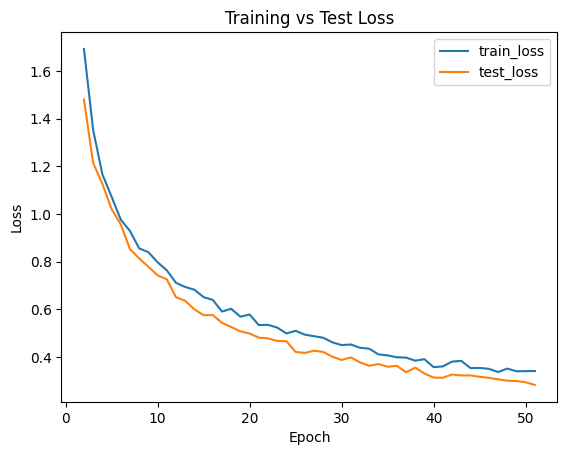

In [86]:
plt.plot(result_df['epoch']+1,result_df['train_loss'], label="train_loss")
plt.plot(result_df['epoch']+1,result_df['test_loss'], label="test_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test Loss")
plt.legend()
plt.show()

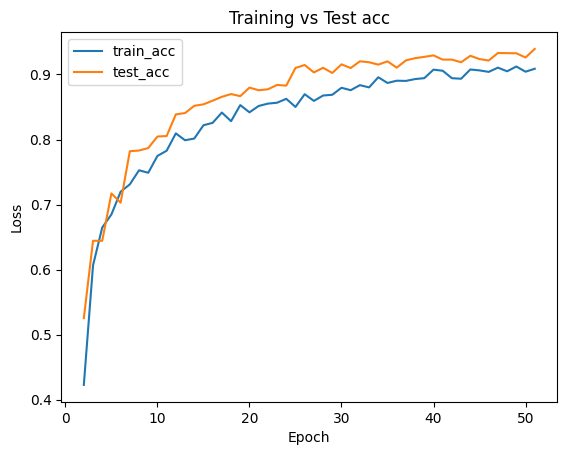

In [87]:
plt.plot(result_df['epoch']+1,result_df['train_acc'], label="train_acc")
plt.plot(result_df['epoch']+1,result_df['test_acc'], label="test_acc")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Test acc")
plt.legend()
plt.show()

In [88]:
def pred_and_plot_image(model, dataset):
    random_samples_idx = random.sample(range(len(dataset)), 12)
    plt.figure(figsize=(30, 10))

    for i, sample_idx in enumerate(random_samples_idx):
        img, label = dataset[sample_idx][0], dataset[sample_idx][1]
        model.eval()
        with torch.inference_mode():
            output = model(img.unsqueeze(0).to(device))
            custom_image_pred_probs = torch.softmax(output, dim=1)
            custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)

        plt.subplot(6, 2, i + 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis("off")
        if custom_image_pred_label == label:
            plt.title(
                f"Actual: {dataset.classes[label]} | Pred: {dataset.classes[custom_image_pred_label]}",
                color="green"
            )
        else:
          plt.title(
            f"Actual: {dataset.classes[label]} | Pred: {dataset.classes[custom_image_pred_label]}",
            color="red"
        )

    plt.tight_layout(pad=2.0)
    plt.show()

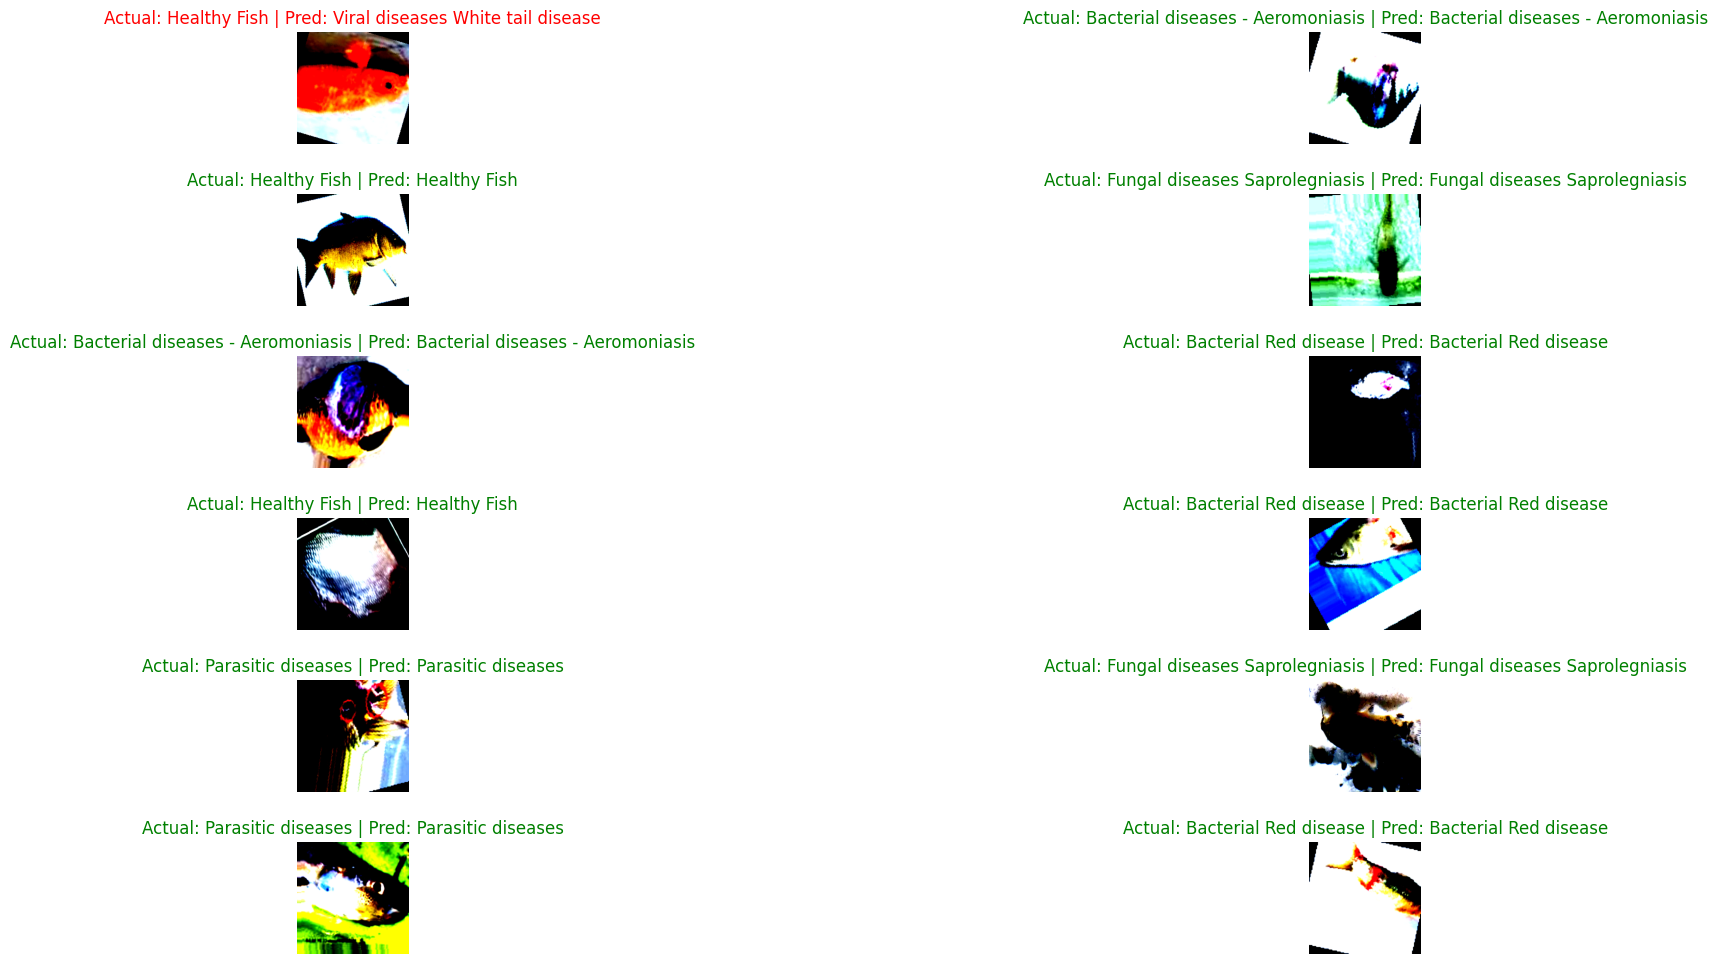

In [89]:
pred_and_plot_image(model, fish_train)

In [90]:
def get_all_preds(model, dataloader):
    all_pred_labels = []
    all_actual_labels = []
    model.eval()
    with torch.inference_mode():
        for img, label in dataloader:
            img , label = img.to(device), label.to(device)
            outputs = model(img)
            custom_image_pred_labels = torch.argmax(torch.softmax(outputs, dim=1), dim=1)
            all_pred_labels.append(custom_image_pred_labels.cpu())
            all_actual_labels.append(label.cpu())

    return torch.cat(all_pred_labels), torch.cat(all_actual_labels)

In [91]:
all_test_preds, all_actual_labels = get_all_preds(model, test_dataloader)
all_test_preds, all_actual_labels

(tensor([1, 2, 4, 0, 3, 4, 4, 1, 4, 4, 0, 4, 3, 0, 6, 0, 0, 1, 1, 3, 3, 4, 4, 4,
         1, 6, 1, 5, 2, 6, 5, 5, 0, 6, 0, 1, 5, 4, 0, 4, 2, 1, 5, 5, 0, 5, 3, 4,
         3, 6, 6, 3, 0, 3, 2, 2, 1, 4, 5, 2, 4, 1, 2, 5, 0, 3, 0, 1, 0, 5, 5, 2,
         1, 2, 4, 5, 5, 5, 5, 1, 6, 3, 3, 4, 2, 2, 3, 1, 0, 0, 4, 0, 1, 6, 0, 4,
         5, 2, 5, 6, 4, 3, 4, 4, 1, 5, 3, 4, 0, 6, 1, 5, 3, 2, 6, 1, 1, 4, 1, 0,
         5, 3, 3, 3, 4, 5, 4, 2, 3, 6, 2, 6, 1, 1, 5, 1, 1, 0, 0, 0, 3, 1, 6, 3,
         5, 0, 5, 0, 2, 4, 6, 1, 6, 0, 5, 2, 0, 5, 2, 0, 6, 6, 5, 0, 0, 0, 3, 4,
         0, 0, 3, 6, 1, 0, 4, 6, 2, 5, 3, 5, 0, 5, 4, 1, 6, 0, 0, 4, 0, 0, 1, 2,
         0, 0, 1, 2, 2, 5, 2, 4, 6, 3, 3, 4, 3, 3, 3, 3, 5, 2, 0, 5, 3, 5, 4, 1,
         2, 2, 3, 2, 5, 3, 6, 4, 6, 2, 6, 3, 5, 0, 0, 2, 4, 2, 3, 5, 4, 3, 3, 4,
         0, 2, 3, 2, 2, 0, 2, 0, 5, 0, 5, 3, 2, 6, 2, 6, 3, 6, 0, 1, 0, 3, 2, 5,
         4, 6, 0, 2, 4, 2, 6, 0, 4, 1, 4, 3, 1, 6, 2, 3, 4, 6, 4, 4, 3, 1, 5, 2,
         3, 6, 1, 2, 4, 3, 1

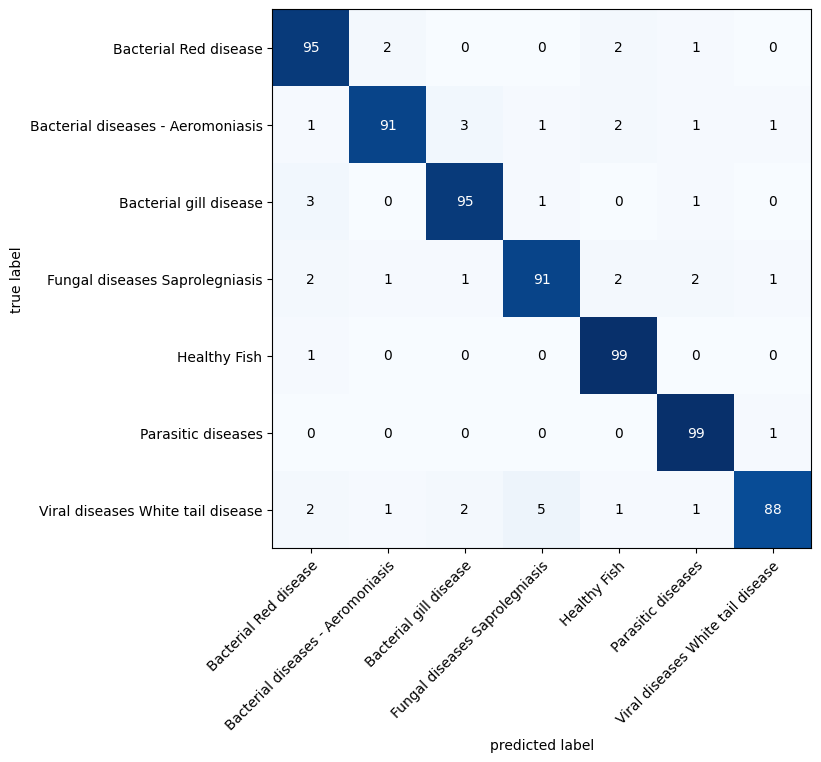

In [93]:
confmat = ConfusionMatrix(num_classes=len(fish_test.classes), task='multiclass')
confmat_tensor = confmat(preds=all_test_preds,target=all_actual_labels)
# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=fish_test.classes, # turn the row and column labels into class names
    figsize=(10, 7)
);

In [94]:
save = torch.save(model.state_dict(), "transfer_fish_model.pth")